## Setup

In [3]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# try:
#   from torchmetrics import ConfusionMatrix
# except:
#   !pip install torchmetrics
#   from torchmetrics import ConfusionMatrix

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device = {device}")

Device = cpu


## Loading Data

In [6]:
import os

dataset_path = "ci/celebrities_images"
count = 0
for root, dirs, files in os.walk(dataset_path):
  if count <= 10:
    print(f"There are {len(dirs)} directories, {len(files)} image files in {root}")
  else:
    break
  count += 1

There are 98 directories, 0 image files in ci/celebrities_images
There are 0 directories, 191 image files in ci/celebrities_images\Aamir Khan
There are 0 directories, 128 image files in ci/celebrities_images\Abhay Deol
There are 0 directories, 149 image files in ci/celebrities_images\Abhishek Bachchan
There are 0 directories, 218 image files in ci/celebrities_images\Aishwarya Rai
There are 0 directories, 173 image files in ci/celebrities_images\Ajay Devgn
There are 0 directories, 170 image files in ci/celebrities_images\Akshay Kumar
There are 0 directories, 54 image files in ci/celebrities_images\Akshaya Khanna
There are 0 directories, 86 image files in ci/celebrities_images\Akshaye Khanna
There are 0 directories, 196 image files in ci/celebrities_images\Alia Bhatt
There are 0 directories, 195 image files in ci/celebrities_images\Amitabh Bachchan


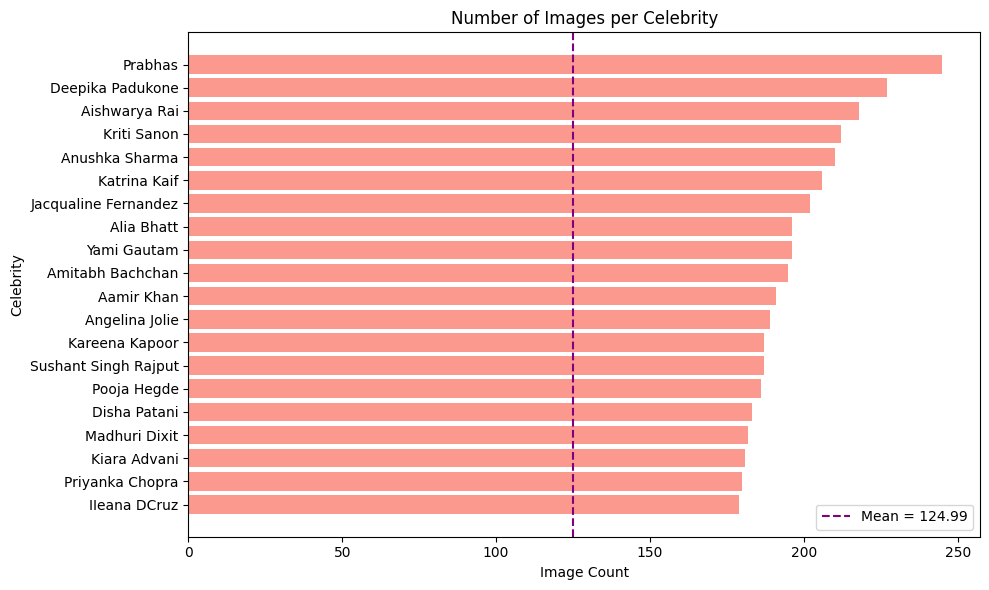

In [7]:
import os

celebrity_image_counts = {}

# Loop through each subfolder and count images
for celebrity in os.listdir(dataset_path):
    celebrity_folder = os.path.join(dataset_path, celebrity)
    if os.path.isdir(celebrity_folder):
        image_files = [file for file in os.listdir(celebrity_folder) if os.path.isfile(os.path.join(celebrity_folder, file))]
        celebrity_image_counts[celebrity] = len(image_files)

# Convert to DataFrame
df_counts = pd.DataFrame(list(celebrity_image_counts.items()), columns=["Celebrity", "Image Count"])
df_counts = df_counts.sort_values(by="Image Count", ascending=False).reset_index(drop=True)

# Visualization function
def visualise_counts(df, n=20):
    df_top_n = df.head(n)
    mean_val = df["Image Count"].mean()
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(df_top_n["Celebrity"], df_top_n["Image Count"], color="salmon", alpha=0.8)
    ax.set(title="Number of Images per Celebrity", xlabel="Image Count", ylabel="Celebrity")
    ax.invert_yaxis()
    ax.axvline(x=mean_val, linestyle='--', color="purple", label=f"Mean = {mean_val:.2f}")
    ax.legend()
    plt.tight_layout()
    plt.show()

visualise_counts(df_counts, 20)

In [15]:
from pathlib import Path

# Setup path to a data folder
image_path = Path("ci/celebrities_images")

In [16]:
import random
from PIL import Image

# Get all image paths
print(image_path)
image_path_list = list(image_path.glob("*/*.jpg"))
image_path_list[:10]

ci\celebrities_images


[WindowsPath('ci/celebrities_images/Aamir Khan/1.jpg'),
 WindowsPath('ci/celebrities_images/Aamir Khan/10.jpg'),
 WindowsPath('ci/celebrities_images/Aamir Khan/101.jpg'),
 WindowsPath('ci/celebrities_images/Aamir Khan/102.jpg'),
 WindowsPath('ci/celebrities_images/Aamir Khan/103.jpg'),
 WindowsPath('ci/celebrities_images/Aamir Khan/104.jpg'),
 WindowsPath('ci/celebrities_images/Aamir Khan/105.jpg'),
 WindowsPath('ci/celebrities_images/Aamir Khan/106.jpg'),
 WindowsPath('ci/celebrities_images/Aamir Khan/107.jpg'),
 WindowsPath('ci/celebrities_images/Aamir Khan/109.jpg')]

Height = 1600 | Width = 1067


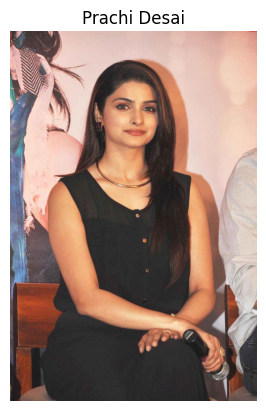

In [17]:
random_path = random.choice(image_path_list)
image_class = random_path.parent.stem
img = Image.open(random_path)

print(f"Height = {img.height} | Width = {img.width}")

plt.imshow(img)
plt.title(image_class)
plt.axis("off")
plt.show()

## Creating data transformations

In [18]:
from torchvision.transforms import v2

IMAGE_SIZE = 224
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

transformed_image = transforms(img)
transformed_image.shape

torch.Size([3, 224, 224])

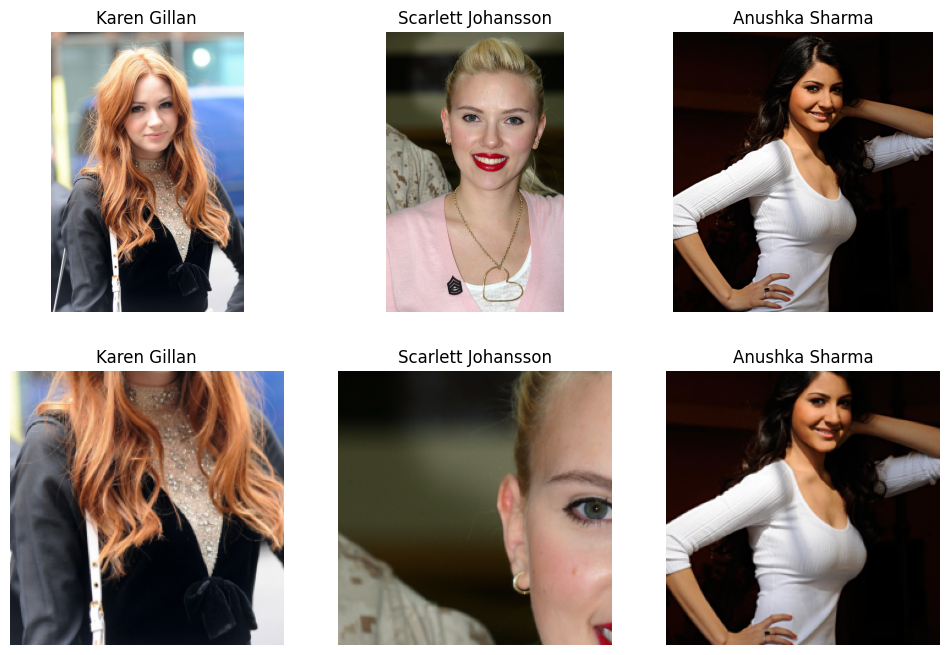

In [19]:
fig, ax = plt.subplots(nrows=2,
                       ncols=3,
                       figsize=(12, 8))

for col in range(3):

  random_path = random.choice(image_path_list)
  image_class = random_path.parent.stem
  img = Image.open(random_path)
  img_transformed = transforms(img).permute(1, 2, 0)

  for row in range(2):

    ax[row, col].set_title(image_class)
    if row == 0:
      ax[row, col].imshow(img)
    else:
      ax[row, col].imshow(img_transformed)
    ax[row, col].axis("off")

plt.show()

## Creating datasets using `ImageFolder`

In [22]:
import torchvision
from torch.utils.data import SubsetRandomSampler, Dataset, DataLoader, Subset

dataset = torchvision.datasets.ImageFolder(dataset_path)

def get_subset(indices, start, end):
    return indices[start : start + end]


TRAIN_PCT, VALIDATION_PCT = 0.7, 0.15  # rest will go for test
train_count = int(len(dataset) * TRAIN_PCT)
validation_count = int(len(dataset) * VALIDATION_PCT)
indices = torch.randperm(len(dataset))
train_indices = get_subset(indices, 0, train_count)
validation_indices = get_subset(indices, train_count, validation_count)
test_indices = get_subset(indices, train_count + validation_count, len(dataset))

BATCH_SIZE = 32

class CustomTransformDataset(Dataset):

  def __init__(self,
               subset,
               transform):
    self.subset = subset
    self.transform = transform

  def __len__(self):
    return len(self.subset)

  def __getitem__(self, idx):
    s = self.subset[idx]
    if self.transform:
      s = self.transform(s)
    return s

def create_dataloaders(dataset_path,
                       batch_size=BATCH_SIZE,
                       train_proportion=0.7,
                       valid_proportion=0.15,
                       test_proportion=0.15,
                       train_transform=None,
                       test_valid_transform=None,
                       proportion_test_set=None,
                       proportion_validation_set=None):

  dataset = torchvision.datasets.ImageFolder(dataset_path)
  class_names = dataset.classes
  # Split indices
  TRAIN_PCT, VALIDATION_PCT = train_proportion, valid_proportion
  total = len(dataset)
  indices = torch.randperm(total).tolist()
  train_end = int(TRAIN_PCT * total)
  val_end = train_end + int(VALIDATION_PCT * total)

  if proportion_test_set:
    assert proportion_test_set <= 1.0
    train_indices = indices[:int(train_end*proportion_test_set)]
  else:
    train_indices = indices[:train_end]
  if proportion_validation_set:
    addition = (val_end - train_end) * proportion_validation_set
    assert train_end < int(train_end+addition)
    val_indices = indices[train_end:int(train_end+addition)]
  else:
    val_indices = indices[train_end:val_end]
  test_indices = indices[val_end:]

  train_subset = Subset(dataset, train_indices)
  val_subset = Subset(dataset, val_indices)
  test_subset = Subset(dataset, test_indices)

  train_dataset = CustomTransformDataset(train_subset, train_transform)
  val_dataset = CustomTransformDataset(val_subset, test_valid_transform)
  test_dataset = CustomTransformDataset(test_subset, test_valid_transform)

  BATCH_SIZE = 32
  return {
      "train": DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
      "validation": DataLoader(val_dataset, batch_size=BATCH_SIZE),
      "test": DataLoader(test_dataset, batch_size=BATCH_SIZE)
  }, class_names


DATASET_PATH = dataset_path
dataloaders, CLASS_NAMES = create_dataloaders(dataset_path=DATASET_PATH)
print(f'Lengths: Train = {len(dataloaders["train"])} | Validation = {len(dataloaders["validation"])} | Test = {len(dataloaders["test"])} | Batch Size = {BATCH_SIZE}')
dataloaders

Lengths: Train = 268 | Validation = 58 | Test = 58 | Batch Size = 32


{'train': <torch.utils.data.dataloader.DataLoader at 0x1edf18d8ec0>,
 'validation': <torch.utils.data.dataloader.DataLoader at 0x1ed8072c910>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1ed8072ce10>}

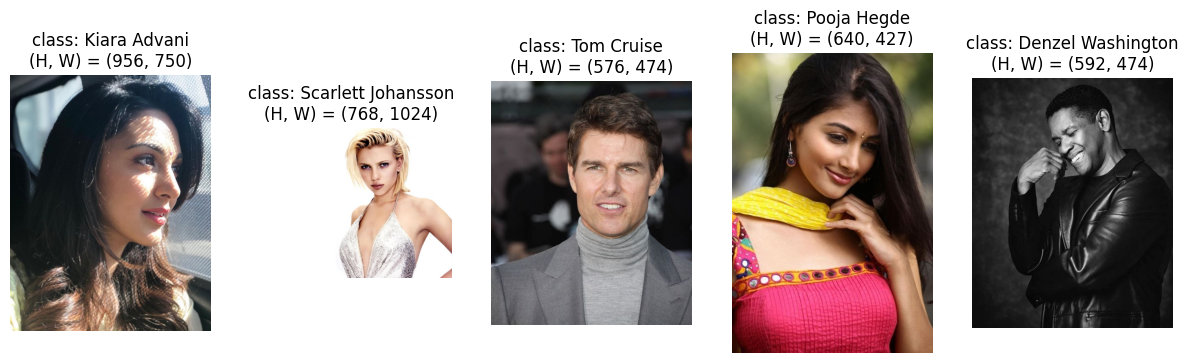

In [23]:
def display_random_images(dataset,
                          classes = None,
                          n = 10,
                          display_shape = True):

    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(15, 5))

    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\n(H, W) = ({targ_image.height}, {targ_image.width})"
        plt.title(title)

display_random_images(dataset, CLASS_NAMES, n=5)

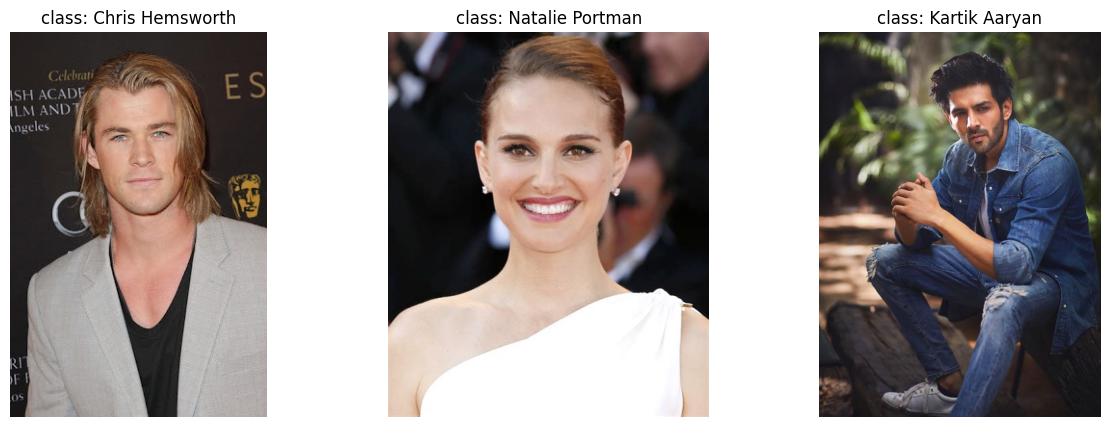

In [25]:
display_random_images(dataset, CLASS_NAMES, n=3, display_shape=False)

## Building TinyVGG model

In [40]:
simple_transform = v2.Compose([v2.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE)),
                               v2.ToImage(),
                               v2.ToDtype(torch.float32, scale=True)])
dataloaders, CLASS_NAMES = create_dataloaders(DATASET_PATH,
                                              train_transform=simple_transform,
                                              test_valid_transform=simple_transform,
                                              proportion_test_set=0.05,
                                              proportion_validation_set=0.05)
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1ed805f1480>,
 'validation': <torch.utils.data.dataloader.DataLoader at 0x1ed805f1d00>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1ed81324350>}

In [41]:
len(dataloaders["train"]), len(dataloaders["validation"]), len(dataloaders["test"])

(14, 3, 58)

### Test if our dataloaders represent entire dataset

In [42]:
def test_dataloaders(dataloaders):
    label_sets = {"train": set(), "validation": set(), "test": set()}
    for split in label_sets:
        print(f"{split.capitalize()}...")
        for batch, (_, y) in enumerate(dataloaders[split]):
            print(batch)
            label_sets[split].update(y.tolist())
            if batch > 3:
                break
    for split in label_sets:
        print(f"{split.capitalize()} labels = {len(label_sets[split])}")

# test_dataloaders(dataloaders)

224 -> 224 -> 112 -> 112 -> 112 -> 56 -> 56

In [43]:
class TinyVGG(nn.Module):

  def __init__(self,
               hidden_units,
               classifier_features=None):
    super(TinyVGG, self).__init__()
    self.sequential_1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.sequential_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 56 * 56, out_features=len(CLASS_NAMES)),
    )

  def forward(self, x):
    # print(x.shape)
    x = self.sequential_1(x)
    # print(x.shape)
    x = self.sequential_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

model_0 = TinyVGG(32).to(device)
model_0

TinyVGG(
  (sequential_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (sequential_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=98, bias=True)
  )
)

In [44]:
BASELINE_MODEL_NAME = "tinyVGG"
BASELINE_MODEL_PATH = f"./Models/{BASELINE_MODEL_NAME}"
BASELINE_MODEL_PATH

'./Models/tinyVGG'

In [45]:
train_dataloader_simple = dataloaders["train"]
img_batch, img_label = next(iter(train_dataloader_simple))

In [46]:
img = img_batch[0]
label = img_label[0]
img = img.unsqueeze(dim=0).to(device)
print(img.shape, label.shape)

with torch.inference_mode():
  logit = model_0(img)

print(f"Shape = {logit.shape}", logit)

torch.Size([1, 3, 224, 224]) torch.Size([])
Shape = torch.Size([1, 98]) tensor([[-6.8329e-04,  1.5300e-02, -7.8314e-03, -2.0220e-02,  2.1464e-02,
         -7.0759e-03, -2.3773e-03,  1.5783e-02, -1.2954e-03, -2.1497e-02,
         -2.0451e-02, -1.2577e-02,  1.7062e-02, -9.3627e-03, -5.3247e-03,
          8.1921e-03,  3.1866e-03, -6.9217e-04, -3.0930e-03,  4.5755e-03,
          1.4821e-02, -1.4121e-02,  1.4841e-02, -1.0755e-03,  8.1763e-04,
         -2.5831e-02, -7.1882e-03, -1.8274e-02, -5.0497e-03, -1.1802e-02,
         -1.2663e-02, -8.7893e-03,  2.1942e-02, -6.2463e-03, -2.1954e-02,
          4.9342e-03, -7.2378e-04, -2.1001e-02, -5.3502e-03, -3.9853e-03,
          4.8823e-03, -4.7473e-04, -1.0606e-02,  1.9955e-02, -1.1909e-02,
         -8.7465e-03,  6.3320e-03, -6.0131e-03, -1.4717e-03,  2.7422e-02,
         -2.7076e-02, -1.0835e-02,  1.2574e-02,  4.1312e-03, -1.0840e-02,
         -7.9869e-03, -1.6191e-02,  1.2708e-02, -1.9405e-02, -3.6145e-03,
          6.1347e-04, -3.1164e-02,  6.55

In [47]:
torch.nn.functional.softmax(logit, dim=1).max()

tensor(0.0105)

## Train and test loops

In [48]:
# !pip install tqdm

In [120]:
from tqdm import tqdm

def train_step(model,
               optimizer,
               loss_fn,
               train_dataloader,
               device,
               display_batch_info=False):
  model.train()
  model.to(device)
  train_loss = 0
  train_accuracy = 0

  # Loop through data
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    logits = model(X)
    loss = loss_fn(logits, y)
    preds = torch.nn.functional.softmax(logits, dim=1).argmax(dim=1)
    accuracy = (preds == y).sum().item() / len(y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Accumulate metrics
    train_loss += loss
    train_accuracy += accuracy

    if display_batch_info:
      if batch%30 == 0:
        print(f"witam w batchu: {batch}")

  train_loss /= len(train_dataloader)
  train_accuracy /= len(train_dataloader)
  return train_loss, train_accuracy

def test_step(model,
              loss_fn,
              test_dataloader,
              device,
              display_batch_info=False):
  model.to(device)
  model.eval()
  test_accuracy = 0
  test_loss = 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader):
      X, y = X.to(device), y.to(device)
      logits = model(X)
      test_loss += loss_fn(logits, y)
      preds = torch.nn.functional.softmax(logits, dim=1).argmax(dim=1)
      test_accuracy += (preds == y).sum().item() / len(y)

      if display_batch_info:
        if batch%30 == 0:
          print(f"witam w batchu testowym: {batch}")
    test_accuracy /= len(test_dataloader)
    test_loss /= len(test_dataloader)
  return test_loss, test_accuracy

EPOCHS = 10
def train(epochs,
          model,
          optimizer,
          loss_fn,
          train_dataloader,
          test_dataloader,
          device,
          display_batch_info=False):
  """
  Combines train_step and test_step functions and train and evaluate the model for given number of epochs.
  """

  # Create empty results dictionary
  results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
  }
  best_test_accuracy = -100
  best_weights=None
  for epoch in tqdm(range(epochs)):
    train_loss, train_accuracy = train_step(model,
                                            optimizer,
                                            loss_fn,
                                            train_dataloader,
                                            device,
                                            display_batch_info)
    test_loss, test_accuracy = test_step(model,
                                         loss_fn,
                                         test_dataloader,
                                         device,
                                         display_batch_info)

    if test_accuracy > best_test_accuracy:
      best_test_accuracy = test_accuracy
      best_weights = model.state_dict()
    print()
    results["train_loss"].append(train_loss.item())
    results["train_acc"].append(train_accuracy)
    results["test_loss"].append(test_loss.item())
    results["test_acc"].append(test_accuracy)
    print(f"Epoch = {epoch}")
    print(f"Training = {train_loss:.4f} | {train_accuracy:.4f} | Testing = {test_loss:.4f} | {test_accuracy:.4f}")

  # Load best weights into model
  if best_weights is not None:
      model.load_state_dict(best_weights)
      print("\n✅ Best model weights loaded based on highest test accuracy.")

  return results

### Training for 5% of the data

In [50]:
len(dataloaders["validation"])

3

In [51]:
len(dataloaders["train"])

14

In [52]:
BASELINE_MODEL_PATH

'./Models/tinyVGG'

In [60]:
import os
from pathlib import Path

optimizer_0 = torch.optim.Adam(params=model_0.parameters())
loss_fn_0 = torch.nn.CrossEntropyLoss()
BASELINE_HISTORY_PATH = "./Histories/tinyVGG_history.csv"

def getting_trained_model(model_path_, history_path, epochs, model, optimizer, loss, dataloaders, device, display_batch):

  # Get model and history paths
  model_path = Path(model_path_)
  model_history_path = Path(history_path)
  print(f"Paths | Model = {model_path} | History = {model_history_path}")

  # Check if model and history exisis
  if model_path.exists() and model_history_path.exists():

    if device == "cpu":
      model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    else:
      model.load_state_dict(torch.load(model_path, weights_only=True))

    history = pd.read_csv(history_path)
    print(f"Loaded tinyVGG model from: {model_path}")
    print(f"Loaded tinyVGG history from: {model_history_path}")

  else:
    print(f"Training on device: {device}")
    history = train(epochs,
                    model,
                    optimizer,
                    loss,
                    dataloaders["train"],
                    dataloaders["validation"],
                    device=device,
                    display_batch_info=display_batch)
    # history.to_csv(pd.DataFrame(model_history_path))
  return model, history

model_0, history_0 = getting_trained_model(BASELINE_MODEL_PATH,
                                           BASELINE_HISTORY_PATH,
                                           3,
                                           model_0,
                                           optimizer_0,
                                           loss_fn_0,
                                           dataloaders=dataloaders,
                                           device=device,
                                           display_batch=True)


Paths | Model = Models\tinyVGG | History = Histories\tinyVGG_history
Training on device: cpu


  0%|          | 0/3 [00:00<?, ?it/s]

witam w batchu: 0
witam w batchu: 1
witam w batchu: 2
witam w batchu: 3
witam w batchu: 4
witam w batchu: 5
witam w batchu: 6
witam w batchu: 7
witam w batchu: 8
witam w batchu: 9
witam w batchu: 10
witam w batchu: 11
witam w batchu: 12
witam w batchu: 13
witam w batchu testowym: 0
witam w batchu testowym: 1


 33%|███▎      | 1/3 [01:20<02:40, 80.44s/it]

witam w batchu testowym: 2

Epoch = 0
Training = 4.5985 | 0.0112 | Testing = 4.5718 | 0.0104
witam w batchu: 0
witam w batchu: 1
witam w batchu: 2
witam w batchu: 3
witam w batchu: 4
witam w batchu: 5
witam w batchu: 6
witam w batchu: 7
witam w batchu: 8
witam w batchu: 9
witam w batchu: 10
witam w batchu: 11
witam w batchu: 12
witam w batchu: 13
witam w batchu testowym: 0
witam w batchu testowym: 1


 67%|██████▋   | 2/3 [02:38<01:19, 79.12s/it]

witam w batchu testowym: 2

Epoch = 1
Training = 4.5222 | 0.0266 | Testing = 4.6834 | 0.0104
witam w batchu: 0
witam w batchu: 1
witam w batchu: 2
witam w batchu: 3
witam w batchu: 4
witam w batchu: 5
witam w batchu: 6
witam w batchu: 7
witam w batchu: 8
witam w batchu: 9
witam w batchu: 10
witam w batchu: 11
witam w batchu: 12
witam w batchu: 13
witam w batchu testowym: 0
witam w batchu testowym: 1


100%|██████████| 3/3 [03:44<00:00, 74.96s/it]

witam w batchu testowym: 2

Epoch = 2
Training = 4.4783 | 0.0290 | Testing = 4.5487 | 0.0104

✅ Best model weights loaded based on highest test accuracy.


In [67]:
print(BASELINE_MODEL_PATH)
BASELINE_MODEL_PATH = "./Models/baseline.pth"
BASELINE_HISTORY_PATH = "./Histories/baseline.csv"
print(BASELINE_MODEL_PATH)
print(BASELINE_HISTORY_PATH)

./Models/baseline.pth
./Models/baseline.pth
./Histories/baseline.csv


In [68]:
pd.DataFrame(history_0)

,train_loss,train_acc,test_loss,test_acc
0,4.598500,0.011161,4.571779,0.010417
1,4.522226,0.026583,4.683442,0.010417
2,4.478297,0.029018,4.548742,0.010417


In [70]:
pd.DataFrame(history_0).to_csv(BASELINE_HISTORY_PATH)


### Visualizaing Training Progress

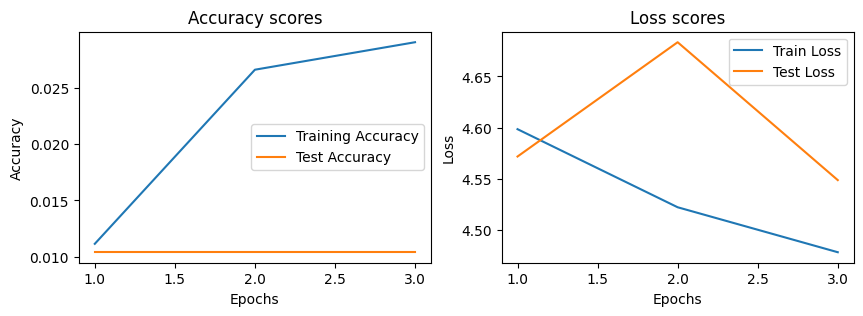

In [72]:
fig = plt.figure(figsize=(10, 3))
epochs = torch.arange(3) + 1

# First subplot for accuracy
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, history_0["train_acc"], label="Training Accuracy")
ax1.plot(epochs, history_0["test_acc"], label="Test Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy scores")
ax1.legend()

# Second subplot for loss
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, history_0["train_loss"], label="Train Loss")
ax2.plot(epochs, history_0["test_loss"], label="Test Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Loss scores")
ax2.legend()

plt.show()

## Function to predict on a custom image

In [73]:
def pred_and_plot_image(model,
                        image_path,
                        class_names=None,
                        transform=None,
                        device='cpu'):
    """Makes a prediction on a target image and plots:
    - the image with predicted label
    - a bar chart of the top 10 class predictions
    """
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255.
    if transform:
        target_image = transform(target_image)
    model.to(device)

    model.eval()
    with torch.inference_mode():
        input_image = target_image.unsqueeze(0).to(device)
        output = model(input_image)

    probs = torch.softmax(output, dim=1).squeeze()
    pred_idx = torch.argmax(probs).item()
    pred_conf = probs[pred_idx].item()

    top_10_idx = torch.topk(probs, k=10).indices.cpu().numpy()
    top_10_values = [probs[i].item() for i in top_10_idx]
    top_10_classes = [class_names[i] for i in top_10_idx] if class_names else [str(i) for i in top_10_idx]

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].imshow(Image.open(image_path))
    pred_label = class_names[pred_idx] if class_names else str(pred_idx)
    ax[0].set_title(f"Predicted: {pred_label}\nConfidence: {pred_conf:.2f}")
    ax[0].axis("off")

    ax[1].barh(top_10_classes, top_10_values, edgecolor='black')
    ax[1].set_xlabel("Confidence")
    ax[1].set_title("Top 10 Predictions")
    ax[1].invert_yaxis()

    plt.tight_layout()
    plt.show()

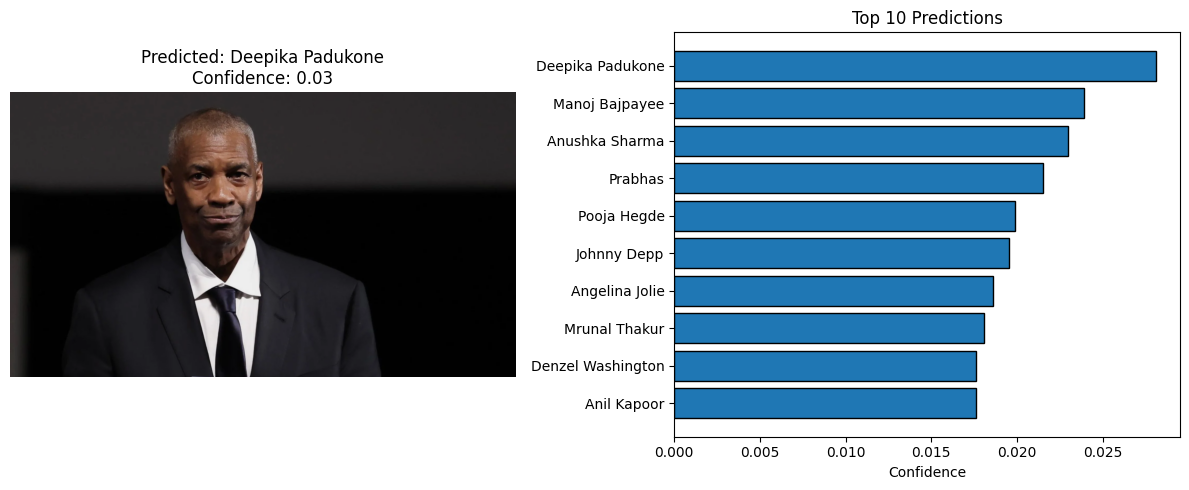

In [75]:
pred_and_plot_image(model_0,
                    "./denzel.jpg",
                    CLASS_NAMES,
                    simple_transform,
                    device)

### Saving baseline Model

Model already saved at: Models\baseline.pth


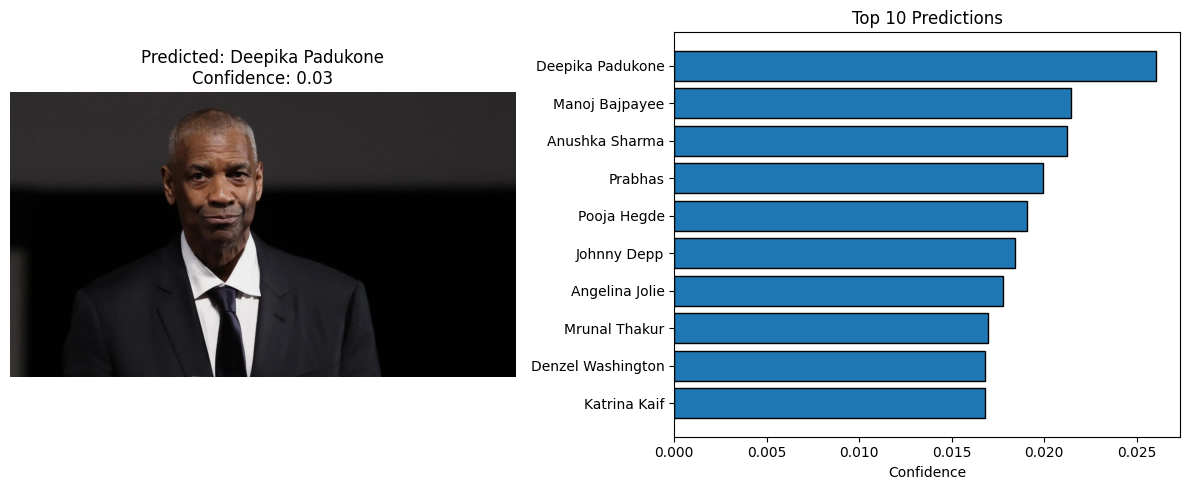

In [81]:
def save_load_and_predict(model, model_path, model_constructor, image_path, class_names, transform, device):
    model_path = Path(model_path)
    model_path.parent.mkdir(parents=True, exist_ok=True)
    if not model_path.exists():
        print(f"Saving model to: {model_path}")
        torch.save(model.state_dict(), model_path)
    else:
        print(f"Model already saved at: {model_path}")
    model_loaded = model_constructor()
    model_loaded.load_state_dict(torch.load(model_path, map_location=device))
    model_loaded.to(device)
    model_loaded.eval()
    pred_and_plot_image(model_loaded, image_path, class_names, transform, device)

save_load_and_predict(
    model=model_0,
    model_path=BASELINE_MODEL_PATH,
    model_constructor=lambda: TinyVGG(32),
    image_path="./denzel.jpg",
    class_names=CLASS_NAMES,
    transform=simple_transform,
    device=device
)

## Trying EfficientNet B0

In [82]:
from torchvision.models import efficientnet_b0

# Get pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT = best available
auto_transforms = weights.transforms()
auto_transforms = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
])

auto_transforms

Compose(
      Resize(size=[256], interpolation=InterpolationMode.BILINEAR, antialias=True)
      CenterCrop(size=(224, 224))
      ToImage()
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [83]:
DATASET_PATH

'ci/celebrities_images'

In [84]:
effn_dataloaders, CLASS_NAMES = create_dataloaders(dataset_path=DATASET_PATH,
                                                  train_transform=auto_transforms,
                                                  test_valid_transform=auto_transforms,
                                                  proportion_test_set=0.2,
                                                   proportion_validation_set=0.2)
effn_dataloaders, CLASS_NAMES[:10]

({'train': <torch.utils.data.dataloader.DataLoader at 0x1ed86792150>,
  'validation': <torch.utils.data.dataloader.DataLoader at 0x1ed86792250>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x1ed86792350>},
 ['Aamir Khan',
  'Abhay Deol',
  'Abhishek Bachchan',
  'Aishwarya Rai',
  'Ajay Devgn',
  'Akshay Kumar',
  'Akshaya Khanna',
  'Akshaye Khanna',
  'Alia Bhatt',
  'Amitabh Bachchan'])

In [85]:
counter = {}
for index, (X, y) in enumerate(effn_dataloaders["train"]):
  print(y, index)
  index += 1
  for v in y:
    v = v.item()
    if v not in counter:
      counter[v] = 0
    else:
      counter[v] += 1
  if index > 2:
      break
print(counter)

tensor([45,  2, 80, 50, 71, 26, 12, 48, 71, 61, 42, 31, 12, 26, 65, 16, 13, 22,
         9, 19, 45, 69, 50, 50, 73,  7,  9, 13, 51, 66, 10, 81]) 0
tensor([24, 46, 38, 34, 31,  7, 17, 22, 96, 32, 78,  3, 91, 45,  2, 84, 65, 65,
        70, 51, 42, 92, 54, 34, 52,  4, 40, 11, 39, 47, 31, 84]) 1
tensor([ 9,  5, 74, 94, 97, 71, 60, 67,  0, 17, 21, 20, 66, 25, 59, 59, 92, 67,
        83, 37, 49, 59, 67, 51, 31, 83,  0, 67, 86, 44, 56, 38]) 2
{45: 2, 2: 1, 80: 0, 50: 2, 71: 2, 26: 1, 12: 1, 48: 0, 61: 0, 42: 1, 31: 3, 65: 2, 16: 0, 13: 1, 22: 1, 9: 2, 19: 0, 69: 0, 73: 0, 7: 1, 51: 2, 66: 1, 10: 0, 81: 0, 24: 0, 46: 0, 38: 1, 34: 1, 17: 1, 96: 0, 32: 0, 78: 0, 3: 0, 91: 0, 84: 1, 70: 0, 92: 1, 54: 0, 52: 0, 4: 0, 40: 0, 11: 0, 39: 0, 47: 0, 5: 0, 74: 0, 94: 0, 97: 0, 60: 0, 67: 3, 0: 1, 21: 0, 20: 0, 25: 0, 59: 2, 83: 1, 37: 0, 49: 0, 86: 0, 44: 0, 56: 0}


In [86]:
len(effn_dataloaders["train"])

54

In [87]:
img_batch, img_label = next(iter(dataloaders["train"]))

In [88]:
from torchvision.models import efficientnet_b0
from torchvision.models import EfficientNet_B0_Weights
eff_net_model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT).to(device)
eff_net_model.features[:2], eff_net_model.avgpool, eff_net_model.classifier

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\User/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100.0%


(Sequential(
   (0): Conv2dNormActivation(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): SiLU(inplace=True)
   )
   (1): Sequential(
     (0): MBConv(
       (block): Sequential(
         (0): Conv2dNormActivation(
           (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
           (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (2): SiLU(inplace=True)
         )
         (1): SqueezeExcitation(
           (avgpool): AdaptiveAvgPool2d(output_size=1)
           (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
           (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
           (activation): SiLU(inplace=True)
           (scale_activation): Sigmoid()
         )
         (2): Conv2dNormActivation(
           (0): Conv2d(32, 16, kernel_size=

In [90]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")

In [91]:
len(CLASS_NAMES)

98

In [92]:
# Freeze model parameters
for param in eff_net_model.features.parameters():
  param.requires_grad = False

eff_net_model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                         nn.Linear(in_features=1280, out_features=len(CLASS_NAMES)))

summary(eff_net_model,
        input_size=(BATCH_SIZE, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 98]                  --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          (6,004)
│    │    └─MBConv: 3-6                      

In [93]:
# Make sure we have 98 classes in out features!!!
eff_net_model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=98, bias=True)
)

In [96]:
eff_net_loss_fn = nn.CrossEntropyLoss()
eff_net_optimizer = torch.optim.Adam(eff_net_model.parameters())
EFFICIENT_NET_MODEL_PATH = f"./Models//efficient_net_B0.pth"
EFFICIENT_NET_HISTORY_PATH = "./Histories/efficient_net_bo.csv"

eff_net_model, effnet_history_20 = getting_trained_model(EFFICIENT_NET_MODEL_PATH,
                                                          EFFICIENT_NET_HISTORY_PATH,
                                                          5,
                                                          eff_net_model,
                                                          eff_net_optimizer,
                                                          eff_net_loss_fn,
                                                          effn_dataloaders,
                                                          device,
                                                          True)

Paths | Model = Models\efficient_net_B0.pth | History = Histories\efficient_net_bo.csv
Training on device: cpu


  0%|          | 0/5 [00:00<?, ?it/s]

witam w batchu: 0
witam w batchu: 5
witam w batchu: 10
witam w batchu: 15
witam w batchu: 20
witam w batchu: 25
witam w batchu: 30
witam w batchu: 35
witam w batchu: 40
witam w batchu: 45
witam w batchu: 50
witam w batchu testowym: 0
witam w batchu testowym: 5
witam w batchu testowym: 10


 20%|██        | 1/5 [04:02<16:10, 242.53s/it]


Epoch = 0
Training = 4.3668 | 0.0466 | Testing = 4.0570 | 0.1016
witam w batchu: 0
witam w batchu: 5
witam w batchu: 10
witam w batchu: 15
witam w batchu: 20
witam w batchu: 25
witam w batchu: 30
witam w batchu: 35
witam w batchu: 40
witam w batchu: 45
witam w batchu: 50
witam w batchu testowym: 0
witam w batchu testowym: 5
witam w batchu testowym: 10


 40%|████      | 2/5 [08:33<12:57, 259.11s/it]


Epoch = 1
Training = 3.5393 | 0.2688 | Testing = 3.7792 | 0.1544
witam w batchu: 0
witam w batchu: 5
witam w batchu: 10
witam w batchu: 15
witam w batchu: 20
witam w batchu: 25
witam w batchu: 30
witam w batchu: 35
witam w batchu: 40
witam w batchu: 45
witam w batchu: 50
witam w batchu testowym: 0
witam w batchu testowym: 5
witam w batchu testowym: 10


 60%|██████    | 3/5 [11:45<07:36, 228.49s/it]


Epoch = 2
Training = 2.9918 | 0.4680 | Testing = 3.5943 | 0.2013
witam w batchu: 0
witam w batchu: 5
witam w batchu: 10
witam w batchu: 15
witam w batchu: 20
witam w batchu: 25
witam w batchu: 30
witam w batchu: 35
witam w batchu: 40
witam w batchu: 45
witam w batchu: 50
witam w batchu testowym: 0
witam w batchu testowym: 5
witam w batchu testowym: 10


 80%|████████  | 4/5 [14:55<03:33, 213.52s/it]


Epoch = 3
Training = 2.5873 | 0.5752 | Testing = 3.4559 | 0.2083
witam w batchu: 0
witam w batchu: 5
witam w batchu: 10
witam w batchu: 15
witam w batchu: 20
witam w batchu: 25
witam w batchu: 30
witam w batchu: 35
witam w batchu: 40
witam w batchu: 45
witam w batchu: 50
witam w batchu testowym: 0
witam w batchu testowym: 5
witam w batchu testowym: 10


100%|██████████| 5/5 [17:43<00:00, 212.63s/it]


Epoch = 4
Training = 2.2367 | 0.6672 | Testing = 3.3736 | 0.2254

✅ Best model weights loaded based on highest test accuracy.


In [98]:
EFFICIENT_NET_HISTORY_PATH, EFFICIENT_NET_MODEL_PATH

('./Histories/efficient_net_bo.csv', './Models//efficient_net_B0.pth')

In [99]:
if not Path(EFFICIENT_NET_HISTORY_PATH).exists():
  print("Saving...")
  pd.DataFrame(effnet_history_20).to_csv(EFFICIENT_NET_HISTORY_PATH)

Saving...


### Save EfficientNet B0

Saving model to: Models\efficient_net_B0.pth


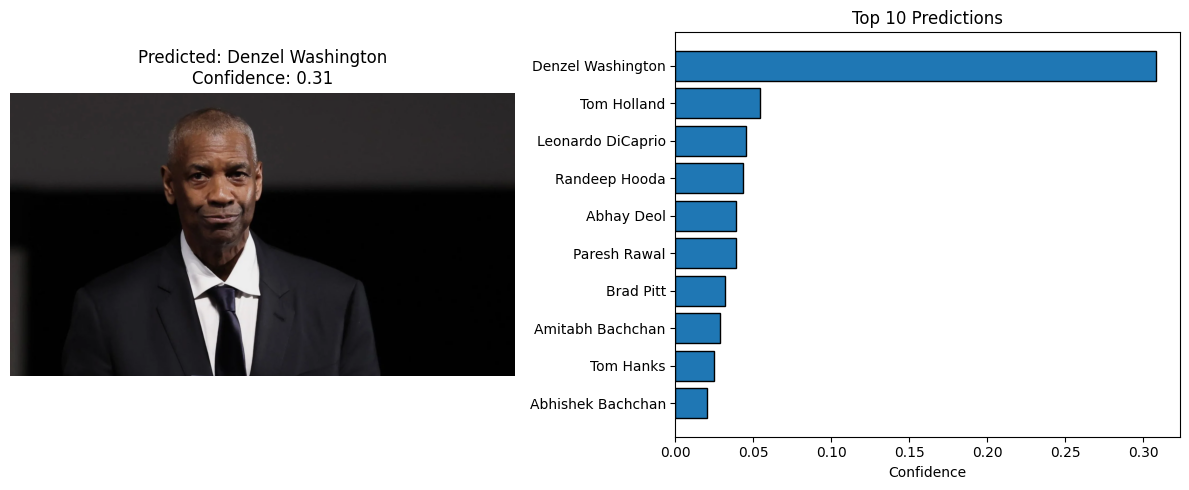

In [100]:
create_eff_net = lambda: (
    (lambda m: (
        [setattr(p, 'requires_grad', False) for p in m.features.parameters()],
        setattr(m, 'classifier', nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(1280, len(CLASS_NAMES))
        )),
        m
    )[-1])(efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT))
)

save_load_and_predict(
    model=eff_net_model,
    model_path=EFFICIENT_NET_MODEL_PATH,
    model_constructor=create_eff_net,
    image_path="./denzel.jpg",
    class_names=CLASS_NAMES,
    transform=auto_transforms,
    device=device
)

## Training EfficientNetBo on 50% of the dataset

In [103]:
effn_dataloaders_50, CLASS_NAMES = create_dataloaders(dataset_path=DATASET_PATH,
                                                      train_transform=auto_transforms,
                                                      test_valid_transform=auto_transforms,
                                                    proportion_test_set=0.5,
                                                    proportion_validation_set=0.25)
effn_dataloaders_50, CLASS_NAMES[:10]

({'train': <torch.utils.data.dataloader.DataLoader at 0x1ed8af02350>,
  'validation': <torch.utils.data.dataloader.DataLoader at 0x1ed8af02150>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x1ed8af02450>},
 ['Aamir Khan',
  'Abhay Deol',
  'Abhishek Bachchan',
  'Aishwarya Rai',
  'Ajay Devgn',
  'Akshay Kumar',
  'Akshaya Khanna',
  'Akshaye Khanna',
  'Alia Bhatt',
  'Amitabh Bachchan'])

In [104]:
len(effn_dataloaders_50["train"])

134

In [105]:
eff_net_model_50 = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT).to(device)
for param in eff_net_model_50.features.parameters():
  param.requires_grad = False

eff_net_model_50.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                             nn.Linear(in_features=1280, out_features=len(CLASS_NAMES)))

In [106]:
eff_net_loss_fn_all = nn.CrossEntropyLoss()
eff_net_optimizer_all = torch.optim.Adam(eff_net_model_50.parameters())

In [107]:
EPOCHS=10
EFFICIENT_NET_MODEL_PATH_50 = "./Models/efficient_net_b0_50_percent_data.pth"
EFFICIENT_NET_HISTORY_PATH_50 = "./Histories/efficient_net_b0_50_percent_data.csv"

eff_net_model_50, effnet_history_50 = getting_trained_model(EFFICIENT_NET_MODEL_PATH_50,
                                                          EFFICIENT_NET_HISTORY_PATH_50,
                                                          10,
                                                          eff_net_model_50,
                                                          eff_net_optimizer_all,
                                                          eff_net_loss_fn_all,
                                                          effn_dataloaders_50,
                                                          device,
                                                          True)

Paths | Model = Models\efficient_net_b0_50_percent_data.pth | History = Histories\efficient_net_b0_50_percent_data.csv
Training on device: cpu


  0%|          | 0/10 [00:00<?, ?it/s]

witam w batchu: 0
witam w batchu: 5
witam w batchu: 10
witam w batchu: 15
witam w batchu: 20
witam w batchu: 25
witam w batchu: 30


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


witam w batchu: 35
witam w batchu: 40
witam w batchu: 45
witam w batchu: 50
witam w batchu: 55
witam w batchu: 60
witam w batchu: 65
witam w batchu: 70
witam w batchu: 75
witam w batchu: 80
witam w batchu: 85
witam w batchu: 90
witam w batchu: 95
witam w batchu: 100
witam w batchu: 105
witam w batchu: 110
witam w batchu: 115
witam w batchu: 120
witam w batchu: 125
witam w batchu: 130
witam w batchu testowym: 0
witam w batchu testowym: 5
witam w batchu testowym: 10


 10%|█         | 1/10 [17:46<2:39:57, 1066.33s/it]


Epoch = 0
Training = 4.0517 | 0.1018 | Testing = 3.5978 | 0.1938
witam w batchu: 0
witam w batchu: 5
witam w batchu: 10
witam w batchu: 15
witam w batchu: 20
witam w batchu: 25
witam w batchu: 30
witam w batchu: 35
witam w batchu: 40
witam w batchu: 45
witam w batchu: 50
witam w batchu: 55
witam w batchu: 60
witam w batchu: 65
witam w batchu: 70
witam w batchu: 75
witam w batchu: 80
witam w batchu: 85
witam w batchu: 90
witam w batchu: 95
witam w batchu: 100
witam w batchu: 105
witam w batchu: 110
witam w batchu: 115
witam w batchu: 120
witam w batchu: 125
witam w batchu: 130
witam w batchu testowym: 0
witam w batchu testowym: 5
witam w batchu testowym: 10


 20%|██        | 2/10 [27:51<1:46:01, 795.18s/it] 


Epoch = 1
Training = 3.1268 | 0.3247 | Testing = 3.2284 | 0.2437
witam w batchu: 0
witam w batchu: 5
witam w batchu: 10
witam w batchu: 15
witam w batchu: 20
witam w batchu: 25
witam w batchu: 30
witam w batchu: 35
witam w batchu: 40
witam w batchu: 45
witam w batchu: 50
witam w batchu: 55
witam w batchu: 60
witam w batchu: 65
witam w batchu: 70
witam w batchu: 75
witam w batchu: 80
witam w batchu: 85
witam w batchu: 90
witam w batchu: 95
witam w batchu: 100
witam w batchu: 105
witam w batchu: 110
witam w batchu: 115
witam w batchu: 120
witam w batchu: 125
witam w batchu: 130
witam w batchu testowym: 0
witam w batchu testowym: 5
witam w batchu testowym: 10


 30%|███       | 3/10 [34:08<1:10:28, 604.09s/it]


Epoch = 2
Training = 2.6159 | 0.4456 | Testing = 3.0103 | 0.2962
witam w batchu: 0
witam w batchu: 5
witam w batchu: 10
witam w batchu: 15
witam w batchu: 20
witam w batchu: 25
witam w batchu: 30
witam w batchu: 35
witam w batchu: 40
witam w batchu: 45
witam w batchu: 50
witam w batchu: 55
witam w batchu: 60
witam w batchu: 65
witam w batchu: 70
witam w batchu: 75
witam w batchu: 80
witam w batchu: 85
witam w batchu: 90
witam w batchu: 95
witam w batchu: 100
witam w batchu: 105
witam w batchu: 110
witam w batchu: 115
witam w batchu: 120
witam w batchu: 125
witam w batchu: 130
witam w batchu testowym: 0
witam w batchu testowym: 5
witam w batchu testowym: 10


 40%|████      | 4/10 [43:14<58:06, 581.14s/it]  


Epoch = 3
Training = 2.2760 | 0.5169 | Testing = 2.8928 | 0.3171
witam w batchu: 0
witam w batchu: 5
witam w batchu: 10
witam w batchu: 15
witam w batchu: 20
witam w batchu: 25
witam w batchu: 30
witam w batchu: 35
witam w batchu: 40
witam w batchu: 45
witam w batchu: 50
witam w batchu: 55
witam w batchu: 60
witam w batchu: 65
witam w batchu: 70
witam w batchu: 75
witam w batchu: 80
witam w batchu: 85
witam w batchu: 90
witam w batchu: 95
witam w batchu: 100
witam w batchu: 105
witam w batchu: 110
witam w batchu: 115
witam w batchu: 120
witam w batchu: 125
witam w batchu: 130
witam w batchu testowym: 0
witam w batchu testowym: 5
witam w batchu testowym: 10


 50%|█████     | 5/10 [55:29<53:03, 636.62s/it]


Epoch = 4
Training = 2.0268 | 0.5728 | Testing = 2.8013 | 0.3296
witam w batchu: 0
witam w batchu: 5
witam w batchu: 10
witam w batchu: 15
witam w batchu: 20
witam w batchu: 25
witam w batchu: 30
witam w batchu: 35
witam w batchu: 40
witam w batchu: 45
witam w batchu: 50
witam w batchu: 55
witam w batchu: 60
witam w batchu: 65
witam w batchu: 70
witam w batchu: 75
witam w batchu: 80
witam w batchu: 85
witam w batchu: 90
witam w batchu: 95
witam w batchu: 100
witam w batchu: 105
witam w batchu: 110
witam w batchu: 115
witam w batchu: 120
witam w batchu: 125
witam w batchu: 130
witam w batchu testowym: 0
witam w batchu testowym: 5
witam w batchu testowym: 10


 60%|██████    | 6/10 [1:02:41<37:49, 567.26s/it]


Epoch = 5
Training = 1.8145 | 0.6260 | Testing = 2.7320 | 0.3379
witam w batchu: 0
witam w batchu: 5
witam w batchu: 10
witam w batchu: 15
witam w batchu: 20
witam w batchu: 25
witam w batchu: 30
witam w batchu: 35
witam w batchu: 40
witam w batchu: 45
witam w batchu: 50
witam w batchu: 55
witam w batchu: 60
witam w batchu: 65
witam w batchu: 70
witam w batchu: 75
witam w batchu: 80
witam w batchu: 85
witam w batchu: 90
witam w batchu: 95
witam w batchu: 100
witam w batchu: 105
witam w batchu: 110
witam w batchu: 115
witam w batchu: 120
witam w batchu: 125
witam w batchu: 130
witam w batchu testowym: 0
witam w batchu testowym: 5
witam w batchu testowym: 10


 70%|███████   | 7/10 [1:08:56<25:12, 504.16s/it]


Epoch = 6
Training = 1.6489 | 0.6599 | Testing = 2.6936 | 0.3525
witam w batchu: 0
witam w batchu: 5
witam w batchu: 10
witam w batchu: 15
witam w batchu: 20
witam w batchu: 25
witam w batchu: 30
witam w batchu: 35
witam w batchu: 40
witam w batchu: 45
witam w batchu: 50
witam w batchu: 55
witam w batchu: 60
witam w batchu: 65
witam w batchu: 70
witam w batchu: 75
witam w batchu: 80
witam w batchu: 85
witam w batchu: 90
witam w batchu: 95
witam w batchu: 100
witam w batchu: 105
witam w batchu: 110
witam w batchu: 115
witam w batchu: 120
witam w batchu: 125
witam w batchu: 130
witam w batchu testowym: 0
witam w batchu testowym: 5
witam w batchu testowym: 10


 80%|████████  | 8/10 [1:15:02<15:20, 460.28s/it]


Epoch = 7
Training = 1.5266 | 0.6861 | Testing = 2.6626 | 0.3421
witam w batchu: 0
witam w batchu: 5
witam w batchu: 10
witam w batchu: 15
witam w batchu: 20
witam w batchu: 25
witam w batchu: 30
witam w batchu: 35
witam w batchu: 40
witam w batchu: 45
witam w batchu: 50
witam w batchu: 55
witam w batchu: 60
witam w batchu: 65
witam w batchu: 70
witam w batchu: 75
witam w batchu: 80
witam w batchu: 85
witam w batchu: 90
witam w batchu: 95
witam w batchu: 100
witam w batchu: 105
witam w batchu: 110
witam w batchu: 115
witam w batchu: 120
witam w batchu: 125
witam w batchu: 130
witam w batchu testowym: 0
witam w batchu testowym: 5
witam w batchu testowym: 10


 90%|█████████ | 9/10 [1:21:31<07:17, 437.85s/it]


Epoch = 8
Training = 1.4130 | 0.7161 | Testing = 2.6499 | 0.3608
witam w batchu: 0
witam w batchu: 5
witam w batchu: 10
witam w batchu: 15
witam w batchu: 20
witam w batchu: 25
witam w batchu: 30
witam w batchu: 35
witam w batchu: 40
witam w batchu: 45
witam w batchu: 50
witam w batchu: 55
witam w batchu: 60
witam w batchu: 65
witam w batchu: 70
witam w batchu: 75
witam w batchu: 80
witam w batchu: 85
witam w batchu: 90
witam w batchu: 95
witam w batchu: 100
witam w batchu: 105
witam w batchu: 110
witam w batchu: 115
witam w batchu: 120
witam w batchu: 125
witam w batchu: 130
witam w batchu testowym: 0
witam w batchu testowym: 5
witam w batchu testowym: 10


100%|██████████| 10/10 [1:28:53<00:00, 533.33s/it]


Epoch = 9
Training = 1.3080 | 0.7374 | Testing = 2.6187 | 0.3692

✅ Best model weights loaded based on highest test accuracy.


In [108]:
EFFICIENT_NET_HISTORY_PATH_50
EFFICIENT_NET_MODEL_PATH_50

'./Models/efficient_net_b0_50_percent_data.pth'

In [109]:
if not Path(EFFICIENT_NET_HISTORY_PATH_50).exists():
  print("Saving...")
  pd.DataFrame(effnet_history_50).to_csv(EFFICIENT_NET_HISTORY_PATH_50)

Saving...


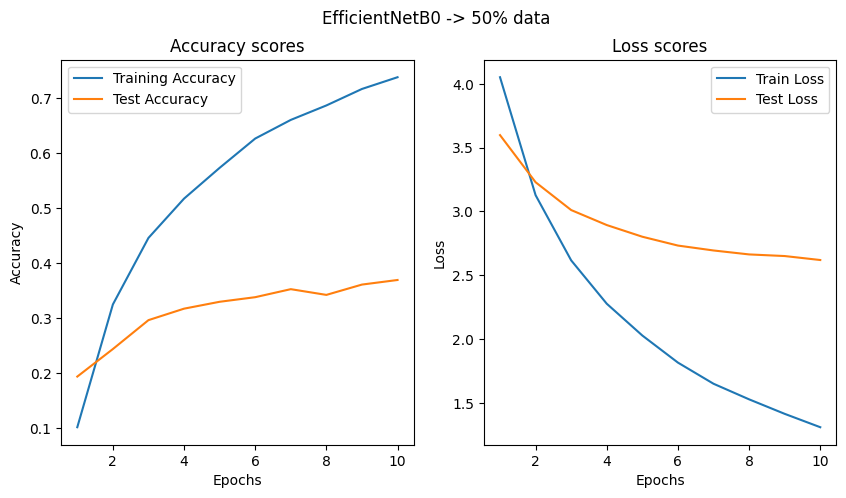

In [110]:
def plot_training(history, epochs, title):
  fig = plt.figure(figsize=(10, 5))
  epochs = torch.arange(epochs) + 1
  fig.suptitle(title)

  # First subplot for accuracy
  ax1 = fig.add_subplot(1, 2, 1)
  ax1.plot(epochs, history["train_acc"], label="Training Accuracy")
  ax1.plot(epochs, history["test_acc"], label="Test Accuracy")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Accuracy")
  ax1.set_title("Accuracy scores")
  ax1.legend()

  # Second subplot for loss
  ax2 = fig.add_subplot(1, 2, 2)
  ax2.plot(epochs, history["train_loss"], label="Train Loss")
  ax2.plot(epochs, history["test_loss"], label="Test Loss")
  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("Loss")
  ax2.set_title("Loss scores")
  ax2.legend()

  plt.show()

plot_training(effnet_history_50, 10, "EfficientNetB0 -> 50% data")

Saving model to: Models\efficient_net_b0_50_percent_data.pth


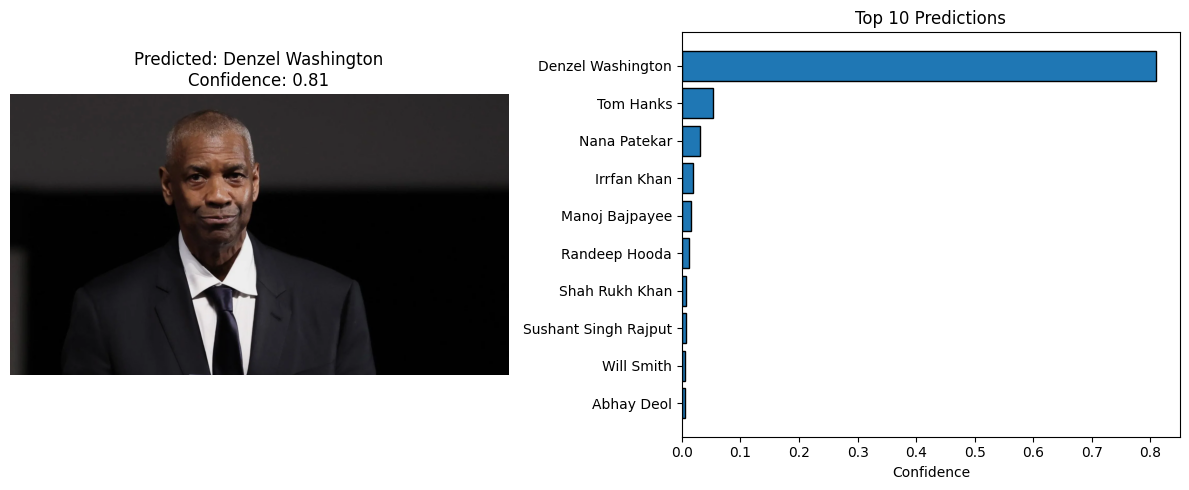

In [113]:
create_eff_net = lambda: (
    (lambda m: (
        [setattr(p, 'requires_grad', False) for p in m.features.parameters()],
        setattr(m, 'classifier', nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(1280, len(CLASS_NAMES))
        )),
        m
    )[-1])(efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT))
)

save_load_and_predict(
    model=eff_net_model_50,
    model_path=EFFICIENT_NET_MODEL_PATH_50,
    model_constructor=create_eff_net,
    image_path="./denzel.jpg",
    class_names=CLASS_NAMES,
    transform=auto_transforms,
    device=device
)

## Training mobilenetV2 with 100 % data

In [114]:
from torchvision.models import mobilenet_v2
from torchvision.models import MobileNet_V2_Weights
mobile_net_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
mobile_weights = MobileNet_V2_Weights.DEFAULT
mobile_net_model.features[:2], mobile_net_model.classifier

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\User/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth


100.0%


(Sequential(
   (0): Conv2dNormActivation(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU6(inplace=True)
   )
   (1): InvertedResidual(
     (conv): Sequential(
       (0): Conv2dNormActivation(
         (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
         (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ReLU6(inplace=True)
       )
       (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
 ),
 Sequential(
   (0): Dropout(p=0.2, inplace=False)
   (1): Linear(in_features=1280, out_features=1000, bias=True)
 ))

In [115]:
for param in mobile_net_model.parameters():
  param.requires_grad = False

mobile_net_model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=False),
                                            nn.Linear(in_features=1280, out_features=len(CLASS_NAMES), bias=True))

weights = torchvision.models.MobileNet_V2_Weights.DEFAULT # DEFAULT = best available
mobile_transforms = mobile_weights.transforms()
print(f"Default = {mobile_transforms}")
mobile_transforms = v2.Compose([
    v2.Resize(232),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
])

mobile_transforms

Default = ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


Compose(
      Resize(size=[232], interpolation=InterpolationMode.BILINEAR, antialias=True)
      CenterCrop(size=(224, 224))
      ToImage()
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [116]:
mobile_dataloaders_all, CLASS_NAMES = create_dataloaders(dataset_path=DATASET_PATH,
                                                       train_transform=mobile_transforms,
                                                       test_valid_transform=mobile_transforms)
mobile_dataloaders_all, CLASS_NAMES[:10]

({'train': <torch.utils.data.dataloader.DataLoader at 0x1ed833f4850>,
  'validation': <torch.utils.data.dataloader.DataLoader at 0x1ed833f4750>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x1ed833f4950>},
 ['Aamir Khan',
  'Abhay Deol',
  'Abhishek Bachchan',
  'Aishwarya Rai',
  'Ajay Devgn',
  'Akshay Kumar',
  'Akshaya Khanna',
  'Akshaye Khanna',
  'Alia Bhatt',
  'Amitabh Bachchan'])

In [121]:
len(mobile_dataloaders_all["train"])

268

In [122]:
EPOCHS=10
MOBILENET_MODEL_PATH = "./Models/mobilenet.pth"
MOBILENET_HISTORY_PATH = "./Histories/mobilenet.csv"
mobile_net_optimizer_all = torch.optim.Adam(mobile_net_model.parameters())
mobile_net_loss_fn_all = nn.CrossEntropyLoss()

mobilenet_model, mobilenet_history = getting_trained_model(MOBILENET_MODEL_PATH,
                                                          MOBILENET_HISTORY_PATH,
                                                          10,
                                                          mobile_net_model,
                                                          mobile_net_optimizer_all,
                                                          mobile_net_loss_fn_all,
                                                          mobile_dataloaders_all,
                                                          device,
                                                          True)

Paths | Model = Models\mobilenet.pth | History = Histories\mobilenet.csv
Training on device: cpu


  0%|          | 0/10 [00:00<?, ?it/s]

witam w batchu: 0
witam w batchu: 30


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


witam w batchu: 60


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


witam w batchu: 90
witam w batchu: 120
witam w batchu: 150
witam w batchu: 180
witam w batchu: 210
witam w batchu: 240
witam w batchu testowym: 0
witam w batchu testowym: 30


 10%|█         | 1/10 [14:20<2:09:05, 860.59s/it]


Epoch = 0
Training = 3.8677 | 0.1314 | Testing = 3.3453 | 0.2511
witam w batchu: 0
witam w batchu: 30
witam w batchu: 60
witam w batchu: 90
witam w batchu: 120
witam w batchu: 150
witam w batchu: 180
witam w batchu: 210
witam w batchu: 240
witam w batchu testowym: 0
witam w batchu testowym: 30


 20%|██        | 2/10 [29:02<1:56:26, 873.30s/it]


Epoch = 1
Training = 2.9676 | 0.3344 | Testing = 2.9694 | 0.3006
witam w batchu: 0
witam w batchu: 30
witam w batchu: 60
witam w batchu: 90
witam w batchu: 120
witam w batchu: 150
witam w batchu: 180
witam w batchu: 210
witam w batchu: 240
witam w batchu testowym: 0
witam w batchu testowym: 30


 30%|███       | 3/10 [43:12<1:40:36, 862.31s/it]


Epoch = 2
Training = 2.5280 | 0.4229 | Testing = 2.7795 | 0.3341
witam w batchu: 0
witam w batchu: 30
witam w batchu: 60
witam w batchu: 90
witam w batchu: 120
witam w batchu: 150
witam w batchu: 180
witam w batchu: 210
witam w batchu: 240
witam w batchu testowym: 0
witam w batchu testowym: 30


 40%|████      | 4/10 [1:04:28<1:42:35, 1025.89s/it]


Epoch = 3
Training = 2.2403 | 0.4880 | Testing = 2.6565 | 0.3572
witam w batchu: 0
witam w batchu: 30
witam w batchu: 60
witam w batchu: 90
witam w batchu: 120


 40%|████      | 4/10 [1:12:19<1:48:29, 1084.93s/it]


KeyboardInterrupt: 

In [ ]:
plot_training(mobile_net_model, EPOCHS, "MobileNetV2 -> 100% data")

In [ ]:
pred_and_plot_image(mobile_net_model,
                    "/content/drive/MyDrive/jl.jpg",
                    CLASS_NAMES,
                    mobile_transforms,
                    device)

# Final Evaluation on the test set

Since `mobilenet` performs best now we will use test set for final evaluation.

In [128]:
eff_net_model_50.eval()
eff_net_model_50.to(device)
test_accuracy = 0
test_loss = 0
final_preds = []
target = []

print(f"Batches = {len(effn_dataloaders_50["test"])}")

with torch.inference_mode():
  for batch, (X, y) in enumerate(effn_dataloaders_50["test"]):
    if batch % 10 == 0:
      print(f"Batch = {batch+1}")
    X, y = X.to(device), y.to(device)
    logits = eff_net_model_50(X)
    test_loss += eff_net_loss_fn_all(logits, y)
    preds = torch.nn.functional.softmax(logits, dim=1).argmax(dim=1)
    test_accuracy += (preds == y).sum().item() / len(y)

    for i, pred in enumerate(preds):
      final_preds.append(pred.item())
      target.append(int(y[i].item()))
  test_accuracy /= len(effn_dataloaders_50["test"])
  test_loss /= len(effn_dataloaders_50["test"])

print(f"(Loss, Accuracy) = {test_loss, test_accuracy}")

Batches = 58
Batch = 1
Batch = 11
Batch = 21
Batch = 31
Batch = 41
Batch = 51
(Loss, Accuracy) = (tensor(2.6306), 0.34288793103448273)


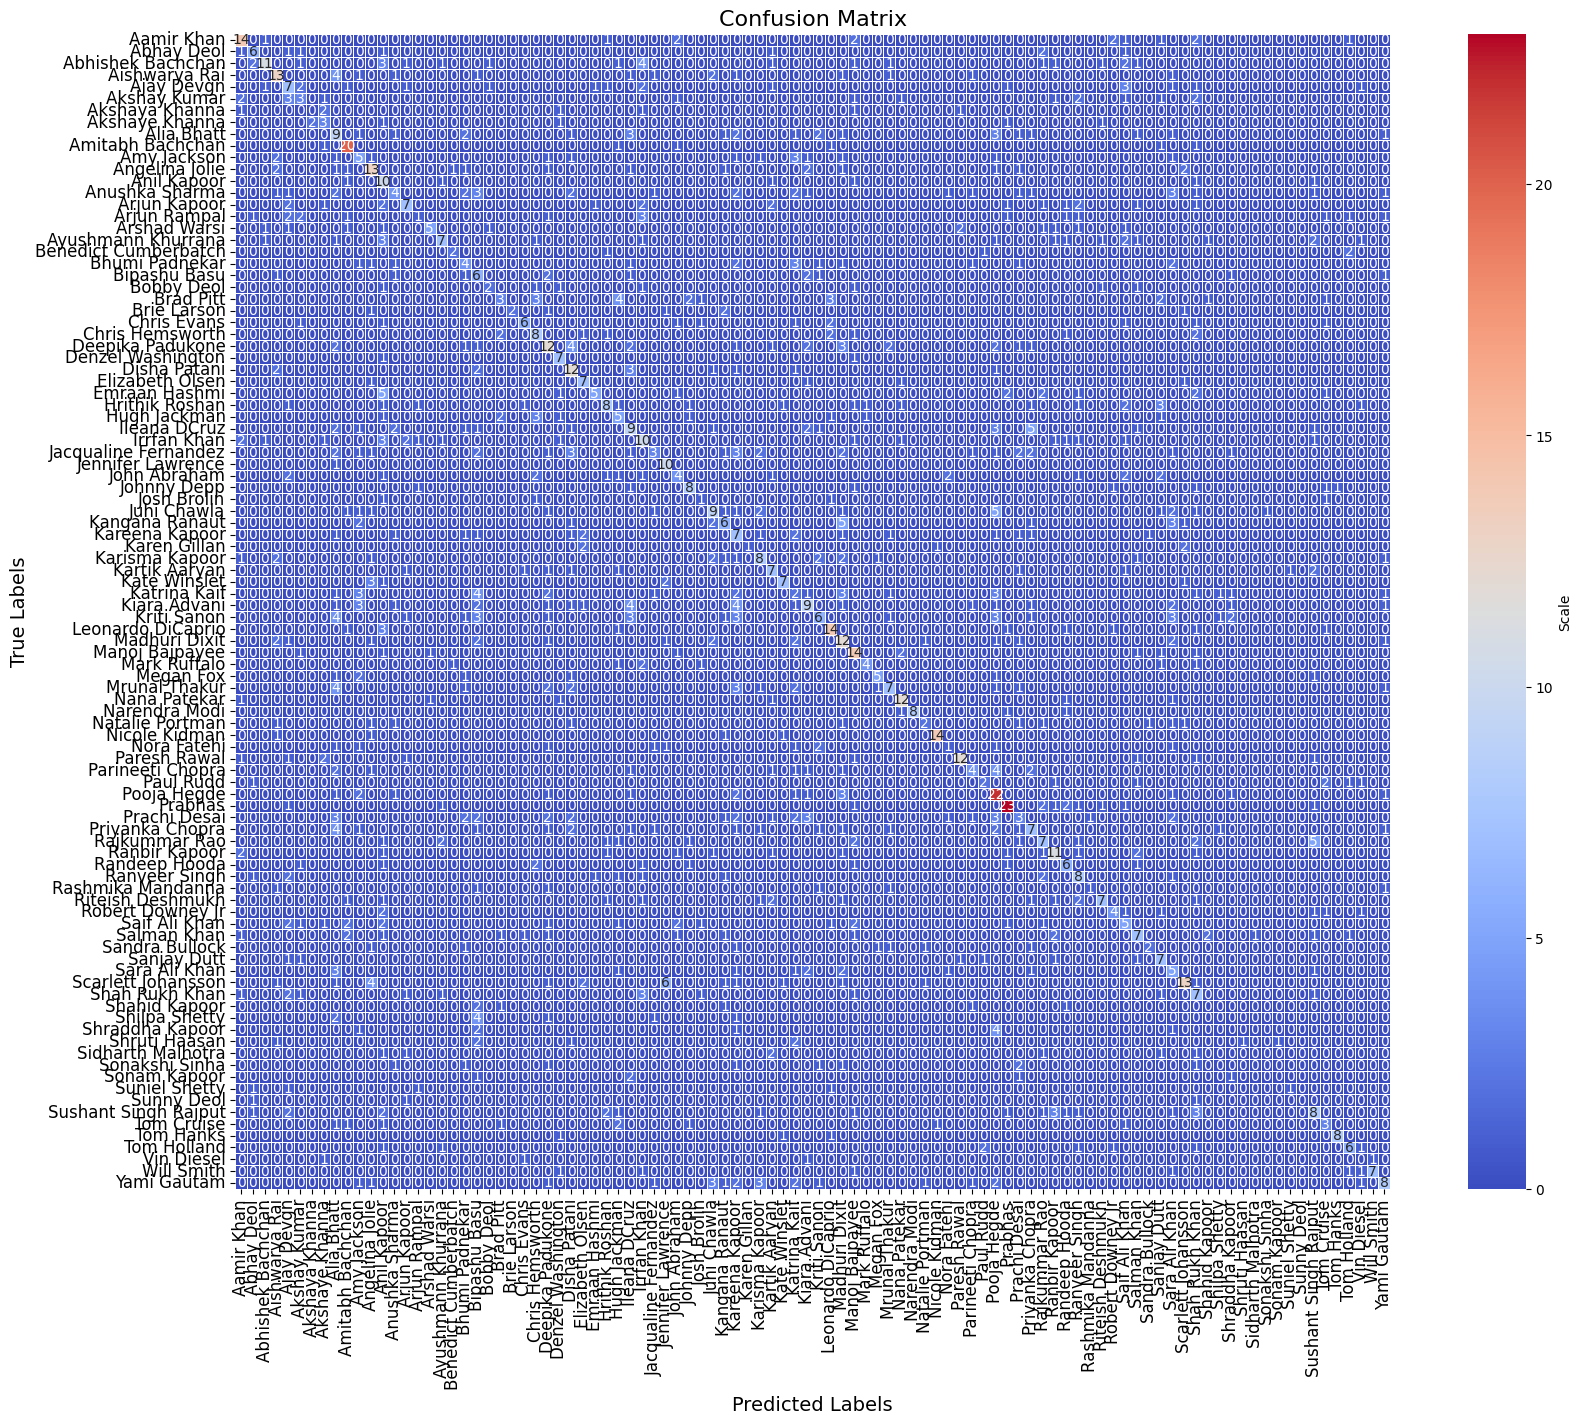

In [129]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(target, final_preds)
class_names = CLASS_NAMES

plt.figure(figsize=(20, 15))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='coolwarm',
            cbar_kws={'label': 'Scale'},
            linewidths=0.5,
            square=True,
            xticklabels=CLASS_NAMES, 
            yticklabels=CLASS_NAMES)

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

END ✅